In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'ggplot2'
plt.style.use('ggplot')
palette = sns.color_palette()

Questions:
- Are there any regular customers? If so, are they the most profitable ones?
- Which product subcategories are responsible for the most negative profit from sales?
- Is there any trend with regard to how different product categories sell over time?
- Is there any pattern with regard to how different product sub-categories sell to different markets?

First, I am going to get a feel for the data:

In [22]:
df = pd.read_csv('superstore.csv', index_col=0)
df.head()

,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,...,product_id,category,sub-category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
row_id,,,,,,,,,,,,,,,,,,,,,
42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,...,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,...,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [23]:
df.loc[df.duplicated()]  # no duplicates

,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,...,product_id,category,sub-category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
row_id,,,,,,,,,,,,,,,,,,,,,


In [24]:
df.info()  # looks like all non-null except postal code

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 42433 to 36388
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        51290 non-null  object 
 1   order_date      51290 non-null  object 
 2   ship_date       51290 non-null  object 
 3   ship_mode       51290 non-null  object 
 4   customer_id     51290 non-null  object 
 5   customer_name   51290 non-null  object 
 6   segment         51290 non-null  object 
 7   city            51290 non-null  object 
 8   state           51290 non-null  object 
 9   country         51290 non-null  object 
 10  postal_code     9994 non-null   float64
 11  market          51290 non-null  object 
 12  region          51290 non-null  object 
 13  product_id      51290 non-null  object 
 14  category        51290 non-null  object 
 15  sub-category    51290 non-null  object 
 16  product_name    51290 non-null  object 
 17  sales           51290 non-n

In [25]:
df.describe()

,postal_code,sales,quantity,discount,profit,shipping_cost
count,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


# Questions
## Question 1: Are there any regular customers? If so, are they the most profitable ones?
I am going to define a regular customer as the customer who has placed orders on different days (regardless of product or quantity purchased). Because the data is broken down by indiviudal products, not by individual orders, and because there is no information on the time of the order (in the case of a customer returning multiple times in the same day), this is a reasonable definition. 

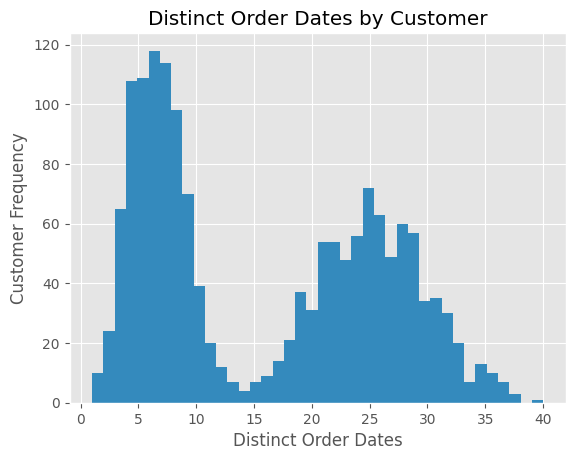

In [26]:
df.groupby(['customer_id'])['order_date'] \
    .nunique() \
    .sort_values(ascending=False) \
    .hist(bins=40, color=palette[1]) \
    .set(title='Distinct Order Dates by Customer', xlabel='Distinct Order Dates', ylabel='Customer Frequency')
plt.show()

The above graph shows that nearly all customers have made purchases on multiple dates, with a few customers returning 35+ times.

Now to the second part of the question, are return customers the most profitable?

In [27]:
# comparing the top 50 most profitable customers with the 50 cutomers with the most unique visit dates
profit_per_customer = df.groupby(['customer_id'])['profit'].sum()
order_days_per_customer = df.groupby(['customer_id'])['order_date'].nunique()
profit_return_df = pd.concat([profit_per_customer, order_days_per_customer], axis=1) \
    .rename(columns={'order_date': 'unique_order_dates'})
profit_return_df.sort_values(by='profit', ascending=False) \
    .head(50) \
    .index \
    .intersection(profit_return_df.sort_values(by='unique_order_dates', ascending=False).head(50).index)

Index(['BE-11335', 'HM-14860', 'SE-20110', 'KD-16495', 'PO-18865', 'AH-10210',
       'DK-13090'],
      dtype='object', name='customer_id')

In [28]:
color = 'rgb' + str(palette[1])
px.scatter(profit_return_df, x='unique_order_dates', y='profit', trendline='ols', width=1000, height=600,
           title='Relationship Between Profit and Number of Distinct Order Dates by Customer',
           labels={'profit': 'Cutomer Profit', 'unique_order_dates': 'Distinct Order Dates'}) \
           .update_traces(marker={'color':color})

The above graph shows that there is a relationship between the number of distinct dates the customer placed an order and the profit per customer. On average, an additional order date results in $74.37 more profit. However, the ten most frequent customers share no overlap with the ten most profitable customers. When this is expanded to the top fifty of each, only seven customers overlap.

## Question 2: Which product sub-categories are responsible for the most negative profit from sales?

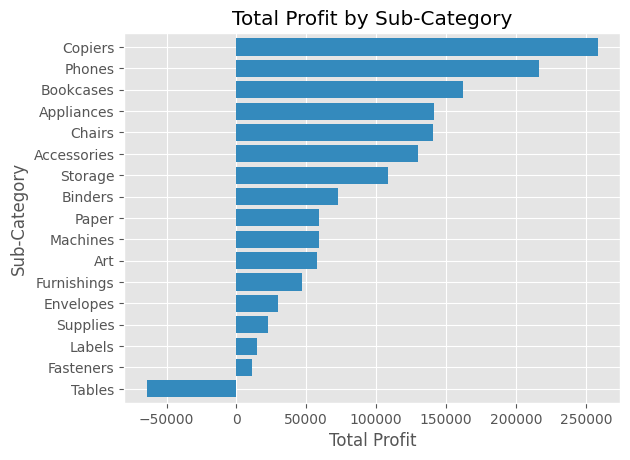

In [29]:
df.groupby('sub-category')['profit'] \
    .sum() \
    .sort_values() \
    .plot(kind='barh', xlabel='Total Profit', ylabel='Sub-Category', title='Total Profit by Sub-Category', width=0.8, color=palette[1])
plt.show()

Tables are the sub-category with the lowest net profit from sales, as displayed in the above graph. I believe this is what the question is asking. However, the question may be asking which sub-category has the highest total losses from unprofitable transactions, instead of highest net losses. The below visualization answers this interpretation of the question:

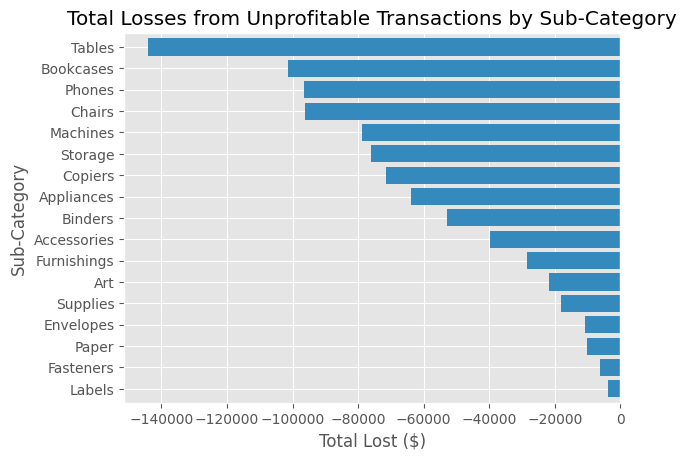

In [30]:
df.query('profit < 0') \
    .groupby('sub-category')['profit'] \
    .sum() \
    .sort_values(ascending=False) \
    .plot(kind='barh', xlabel='Total Lost ($)', ylabel='Sub-Category', 
          title='Total Losses from Unprofitable Transactions by Sub-Category', width=0.8, color=palette[1])
plt.show()

Tables remain the sub-category responsible for the most negative profit from sales. 

## Question 3: Is there any trend with regard to how different product categories sell over time?

In [31]:
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True)

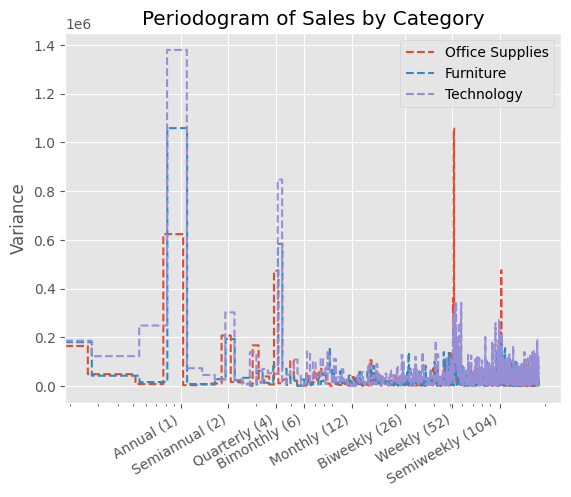

In [32]:
# much of this function is copied from https://www.kaggle.com/code/ryanholbrook/seasonality

from scipy.signal import periodogram

def create_periodogram(df: pd.DataFrame):
    '''
    Creates a periodogram on sales data, with a different line for each category
    '''
    periodogram_data = []

    # fs is the sampling frequency of the periodogram
    fs = pd.Timedelta(days=365) / pd.Timedelta(days=1)

    categories = df['category'].unique()

    # create periodogram data for each category
    for cat in categories:
        series_to_analyze = pd.Series(
            df.query('category == @cat').groupby('order_date')['sales'].sum())
        frequency, spectrum = periodogram(
            series_to_analyze, fs=fs, detrend='linear',)
        periodogram_data.append([frequency, spectrum, cat])

    # initialize the plot
    _, ax = plt.subplots()

    # add the lines with unique colors
    for i in range(len(periodogram_data)):
        ax.step(x=periodogram_data[i][0],
                y=periodogram_data[i][1],
                label=periodogram_data[i][2],
                color=palette[i % 7],
                linestyle='dashed')

    # format the plot
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
        ha='right' # changed to bettern align ticks
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    ax.set_ylabel("Variance")
    ax.legend()
    ax.set_title('Periodogram of Sales by Category')
    return ax


create_periodogram(df)
plt.show()

From the periodogram, we can see  clear annual, semiannually, biweekly, and weekly seasonality in the sales data. Technology shows the highest level of annual and quartly seasonality, with slight quarterly, biweekly and weekly seasonality. Furniture sales show high annual and quarterly seasonality. Office supplies have a high degree of weekly seasonality, followed by a lower degree of annual, quarterly, and semiweekly seasonality. 

Now, I will plot the long-term tends:

In [33]:
def product_category_over_time(df: pd.DataFrame, voi: str, label: str, lowess_frac: float = 0.1):
    '''
    Takes dataframe, variable of interest (voi), and label for Y column. Returns a plotly graph of the trendline of the voi over time
    '''
    # first we create a catagory dataframe
    categories = df['category'].unique()
    category_series = []
    for category in categories:
        category_series.append(df.query(
            'category == @category').groupby('order_date')[voi].sum().rename(category))
    category_df = pd.concat([x for x in category_series], axis=1).reset_index()

    # now we create a scatterplot
    fig = px.scatter(category_df, x='order_date', y=categories, trendline='lowess',
                     trendline_options={'frac': lowess_frac}, height=400, width=1000,
                     title=f'{label} by Category, 2011-2014',
                     labels={'value': label, 'order_date': 'Date', 'variable': 'Category'})

    # Only display trendlines to avoid clutter
    fig.data = fig.data[1::2]

    # add legend back
    for i in range(3):
        fig.data[i]['showlegend'] = True

    return fig

product_category_over_time(df=df, voi='sales', label='Sales ($)')
# product_category_over_time(df=df, voi='profit', label='Profit ($)')
# product_category_over_time(df=df, voi='quantity', label='Quantity Sold')

The sales of all three categories have increased over the period 2011-2014, with an especially good year in 2014. The annual seasonality discovered above is clearly evident in the above graph. 

## Question 4: Is there any pattern with regard to how different product sub-categories sell to different markets?

I am going to answer this question by first finding an expected sales value defined by the portion of all sales each market and sub-category repersents, and then compare the expected value with the actual value. This method will clearly illustrate which sub-categories under and over perform in which markets.

In [34]:
market_category_df = pd.DataFrame(df.groupby(['market', 'sub-category']).sum(numeric_only=True)).reset_index()

total_sales_by_subcat = df.groupby('sub-category')['sales'].sum()
market_prop_sales = df.groupby('market')['sales'].sum() / df['sales'].sum()

market_category_df['expected_sales'] = market_category_df \
    .apply(lambda x: total_sales_by_subcat[x['sub-category']] * market_prop_sales[x['market']], axis=1)
market_category_df['realized_percent'] = (market_category_df['sales'] / market_category_df['expected_sales']) * 100

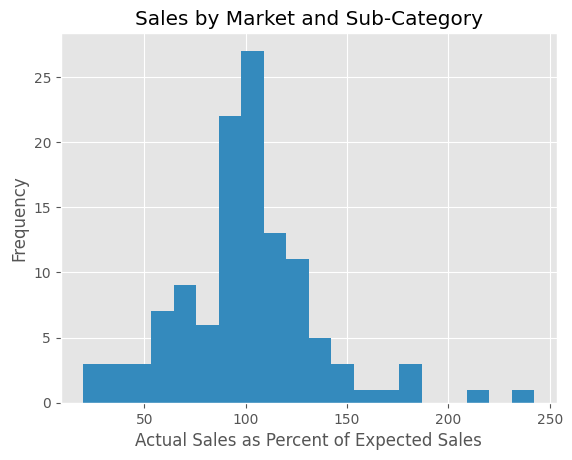

In [35]:
market_category_df['realized_percent'].hist(bins=20, color=palette[1]) \
    .set(xlabel='Actual Sales as Percent of Expected Sales', ylabel='Frequency', title='Sales by Market and Sub-Category')
plt.show()

The histogram shows us that while most sub-categories are near what is expected for the markets, sub-categories in some markets significantly over or under perform. Lets see which ones:

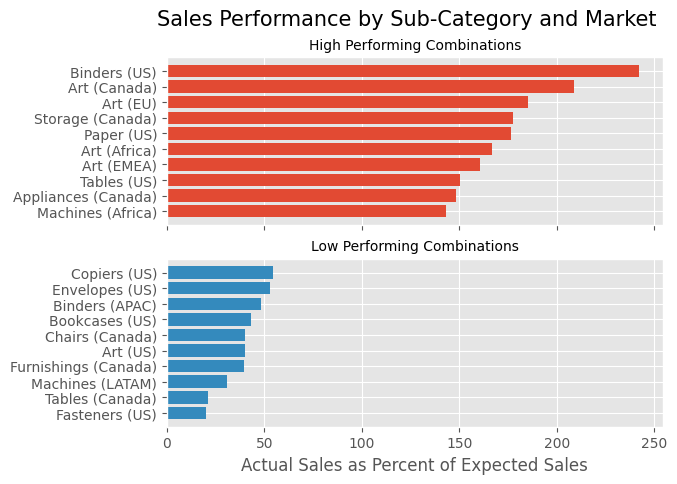

In [36]:
market_category_df['bar_label'] = market_category_df['sub-category'] + ' (' + market_category_df['market'] + ')'

temp = market_category_df.sort_values('realized_percent')
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle('Sales Performance by Sub-Category and Market', size=15)
ax[0].barh(y=temp.tail(10)['bar_label'], width=temp.tail(10)['realized_percent'])
ax[0].set_title('High Performing Combinations', size=10)
ax[1].barh(y=temp.head(10)['bar_label'], width=temp.head(10)['realized_percent'], color=palette[1])
ax[1].set_title('Low Performing Combinations', size=10)
ax[1].set_xlabel('Actual Sales as Percent of Expected Sales')
plt.show()

As we can see above, binders in the US and art in Canada are over-performing, while fastners in the US and tables in Canada are under-perfoming. The above graph answers question four.

## Bonus: Rereading Question 4
The question 'Is there any pattern with regard to how different product sub-categories sell to different markets?' could be interpreted as asking what underlying mechanics  drive the difference in sub-category sales between markets. For example, does a higher larger home consumer market drive Canada's art sales while depressing their table sales? To answer this question, I will make a correlation heat map to see if any variables correlated with higher or lower subcategory sales.

In [37]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
sklearn.set_config(transform_output='pandas') 


# create dummies for different consumer segments
ohe = OneHotEncoder(sparse_output=False)
segement_dummies = ohe.fit_transform(df[['segment']]) \
    .rename(columns={'segment_Consumer':'segment_consumer','segment_Corporate':'segment_corporate','segment_Home Office':'segment_home_office'})
df_with_ohe = df.join(segement_dummies)
model_df = pd.DataFrame(df_with_ohe.groupby(['market', 'sub-category']).mean(numeric_only=True)).reset_index()

# rather hacky way to add in the realized_percent without having to rewrite the cell -- ideally, I would put it in a function
market_category_df['label'] = market_category_df['market'] + ' ' + market_category_df['sub-category']
model_df = model_df \
    .assign(label = model_df['market'] + ' ' + model_df['sub-category']) \
    .rename(columns={'sub-category':'subcategory'}) \
    .set_index('label') \
    .join(market_category_df.set_index('label')['realized_percent']) \
    .dropna(axis=1)

model_df.head()

,market,subcategory,sales,quantity,discount,profit,shipping_cost,segment_consumer,segment_corporate,segment_home_office,realized_percent
label,,,,,,,,,,,
APAC Accessories,APAC,Accessories,266.430951,3.748212,0.184235,22.722624,29.311144,0.533619,0.288984,0.177396,87.638786
APAC Appliances,APAC,Appliances,910.120500,3.875740,0.123077,124.641151,94.115237,0.529586,0.286982,0.183432,107.273031
APAC Art,APAC,Art,94.323473,3.588323,0.153862,10.986138,9.748817,0.529940,0.284431,0.185629,59.703485
APAC Binders,APAC,Binders,65.831129,3.669430,0.112311,11.189254,6.997150,0.558549,0.279793,0.161658,48.490155
APAC Bookcases,APAC,Bookcases,809.011344,3.783654,0.114535,108.423892,85.217372,0.530449,0.286859,0.182692,121.363886


We have now created a dataframe with a row for each market and sub-category. Each row contains the percent of sales for the sub-category and market compared to the expected sales. Each row also includes metrics on the market, such as mean sales, quantity, and discount, as well as proportion of consumers by segment. Using each market as a seperate data point, I will find the correlation coefficients between the sale of a sub-category and the explanatory variables.

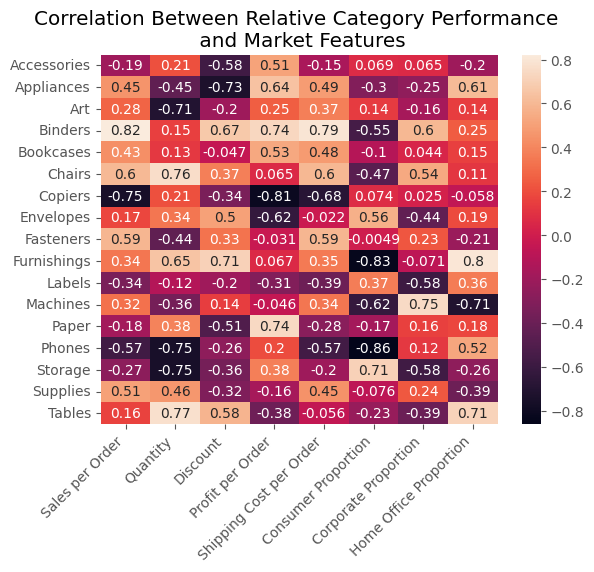

In [38]:
correlation_dic = {}
for subcat in model_df['subcategory'].unique():
    correlation_dic[subcat] = model_df \
        .query('subcategory == @subcat') \
        .set_index('market', drop=True) \
        .drop('subcategory', axis=1) \
        .corr()['realized_percent']
    
feature_names = {
    'sales':'Sales per Order',
    'discount': 'Discount',
    'quantity':'Quantity',
    'profit':'Profit per Order',
    'shipping_cost':'Shipping Cost per Order',
    'segment_consumer':'Consumer Proportion',
    'segment_corporate':'Corporate Proportion',
    'segment_home_office': 'Home Office Proportion'
}

correlation_df = pd.DataFrame(correlation_dic).drop('realized_percent').T.rename(columns=feature_names)

sns.heatmap(correlation_df, annot=True).set(title='Correlation Between Relative Category Performance \n and Market Features')
plt.xticks(rotation=45, ha='right')
plt.show()

The above heatmap provides some insight. The consumer propotion of the market is highly negatively correlated with phone and furnishings (suprising - I verified below), while sales per order is highly correlated with binders, and home office proportion is highly correlated with furnishings. However, given the small sample size of seven markets, this heatmap is likely picking up on a lot of noise. If I were to continue on this project, I would recreate the heatmap on a more granular level.

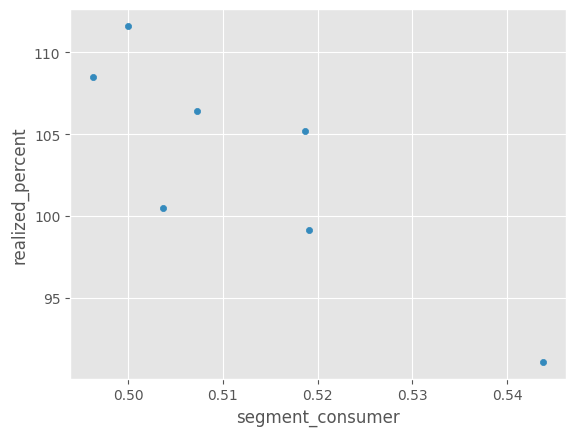

In [39]:
model_df.query('subcategory == "Phones"') \
    .set_index('market', drop=True) \
    .drop('subcategory', axis=1) \
    .plot(kind='scatter', x='segment_consumer',y='realized_percent')
plt.show()

Fine, lets do it by geographic region

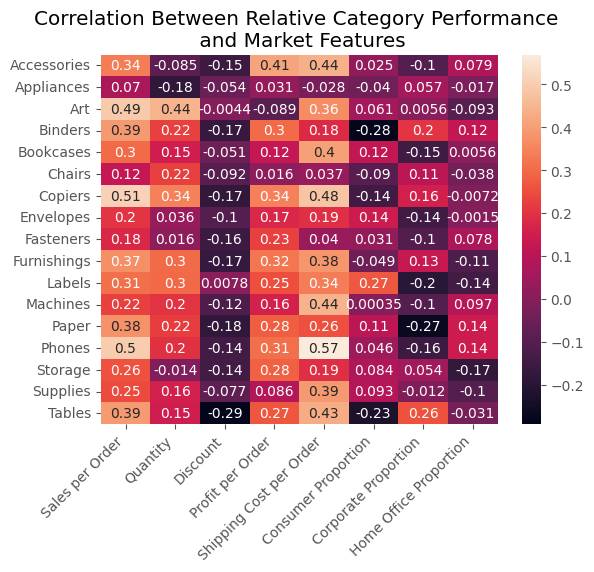

In [40]:
def heatmap_by_geographical_size(df: pd.DataFrame, df_with_ohe: pd.DataFrame, geography: str) -> None:
    '''
    Geography refers to the column to create the correlation matrix with respect to
    '''
    model_df = pd.DataFrame(df_with_ohe.groupby([geography, 'sub-category']).mean(numeric_only=True)).reset_index()


    total_sales_by_subcat = df.groupby('sub-category')['sales'].sum()
    prop_sales = df.groupby(geography)['sales'].sum() / df['sales'].sum()

    model_df['expected_sales'] = model_df.apply(lambda x: total_sales_by_subcat[x['sub-category']] * prop_sales[x[geography]], axis=1)
    model_df['realized_percent'] = (model_df['sales'] / model_df['expected_sales']) * 100


    model_df = model_df \
        .rename(columns={'sub-category':'subcategory'}) \
        .dropna(axis=1) \
        .drop('expected_sales', axis=1)

    correlation_dic = {}
    for subcat in model_df['subcategory'].unique():
        correlation_dic[subcat] = model_df \
            .query('subcategory == @subcat and realized_percent < 500') \
            .set_index(geography, drop=True) \
            .drop('subcategory', axis=1) \
            .corr()['realized_percent']
        
    feature_names = {
        'sales':'Sales per Order',
        'discount': 'Discount',
        'quantity':'Quantity',
        'profit':'Profit per Order',
        'shipping_cost':'Shipping Cost per Order',
        'segment_consumer':'Consumer Proportion',
        'segment_corporate':'Corporate Proportion',
        'segment_home_office': 'Home Office Proportion'
    }

    correlation_df = pd.DataFrame(correlation_dic).drop('realized_percent').T.rename(columns=feature_names)

    sns.heatmap(correlation_df, annot=True).set(title='Correlation Between Relative Category Performance \n and Market Features')
    plt.xticks(rotation=45, ha='right')
    plt.show()

heatmap_by_geographical_size(df, df_with_ohe, geography='country')

Completely different results! Changing the geographic designation between region, country and market produces different results. It is very possible that the correlations are just picking up on noise, but further investigation is needed.